## **Sismograma sintético**

**Douglas Alberto Gómez Reyes, noviembre de 2017**

Partiendo de la filosofía de [reproducibilidad computacional](http://www.ahay.org/wiki/Reproducibility?setlang=es) en ciencias de la tierra ([también ver aquí](http://www.journals.unam.mx/index.php/ingenieria/article/view/30838)), este ejercicio tiene por objetivo calcular una traza sintética y su espectro de potencia y fase del pozo F03-4 del conjunto de datos libres [Netherlands Offshore F3 Block](http://www.opendtect.org/osr/Main/NetherlandsOffshoreF3BlockComplete4GB), adaptando y modificando parte de la secuencia de comandos de [Bianco (2014)](https://library.seg.org/doi/10.1190/tle33060674.1).

Este cuaderno describe la lectura de los datos del registros geofísicos del pozo F03-4, exportado de [OpendTect](https://dgbes.com/) en formato csv, y el cálculo del sismograma sintético a partir de una ondícula de Ricker de 25 Hz de fase cero. El archivo en formato LAS se puede encontrar [aquí.](http://www.nlog.nl/nlog/requestData/nlogp/allBor/metaData.jsp?tableName=BorLocation&id=106523731)

**Nota: En agosto de 2023, se cargó en Colab esta secuencia de comandos (script), y se agregaron líneas adicionales para comparar el resultado de la Prueba de Concepto utilizando ChatGPT-4.**

In [1]:
well_log='/content/drive/MyDrive/Colab Notebooks/Well_F03-4.csv'

In [2]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [3]:
reg=pd.read_csv(well_log)
reg.columns

Index(['Depth', 'Density', 'P_Slowness', 'Gamma_Ray', 'Porosity_Frac',
       'P_Impedance', 'P_Impedance-rel'],
      dtype='object')

In [4]:
reg[['Depth', 'Density', 'P_Slowness', 'Gamma_Ray', 'Porosity_Frac','P_Impedance', 'P_Impedance-rel']].describe()

,Depth,Density,P_Slowness,Gamma_Ray,Porosity_Frac,P_Impedance,P_Impedance-rel
count,12467.000000,12467.000000,12467.000000,12467.000000,12467.000000,1.246700e+04,12467.000000
mean,949.909211,1671.126495,-2513.370321,-171.674114,-371.025110,4.253690e+06,1439.670555
std,548.496334,2292.885303,4735.577767,1462.328306,1890.949234,9.532833e+05,105585.123392
min,0.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9.999000e+03,-368205.031300
25%,474.954600,2078.474350,-9999.000000,28.750000,0.297250,4.090630e+06,-37871.101600
50%,949.909200,2120.100000,453.723100,43.709600,0.327600,4.376170e+06,42.011800
75%,1424.863850,2167.600000,500.202300,61.150000,0.352700,4.738070e+06,47294.103550
max,1899.818500,2310.277300,594.700300,104.350000,0.452500,6.139820e+06,504566.000000


In [5]:
print ('Tipo de dato de la columna P_Slowness : ',type(reg['P_Slowness']))

Tipo de dato de la columna P_Slowness :  <class 'pandas.core.series.Series'>


In [6]:
z = reg['Depth'] # Metros
den = reg['Density'] # g/cm3
dtco = reg['P_Slowness'] #us/m
gr = reg['Gamma_Ray'] #API
phi = reg['Porosity_Frac'] #[1]

Para obtener la relación de conversión profundidad a tiempo, debemos realizar la suma acumulada del registro sónico (tacum), a partir del intervalo de tiempo donde inicia el registro sónico. Para ello, a partir de la visualización de los datos en OpendTect se tiene el intervalo de inicio (tini) a partir de 500 ms, señalado con la flecha de color blanco en la imagen inferior.

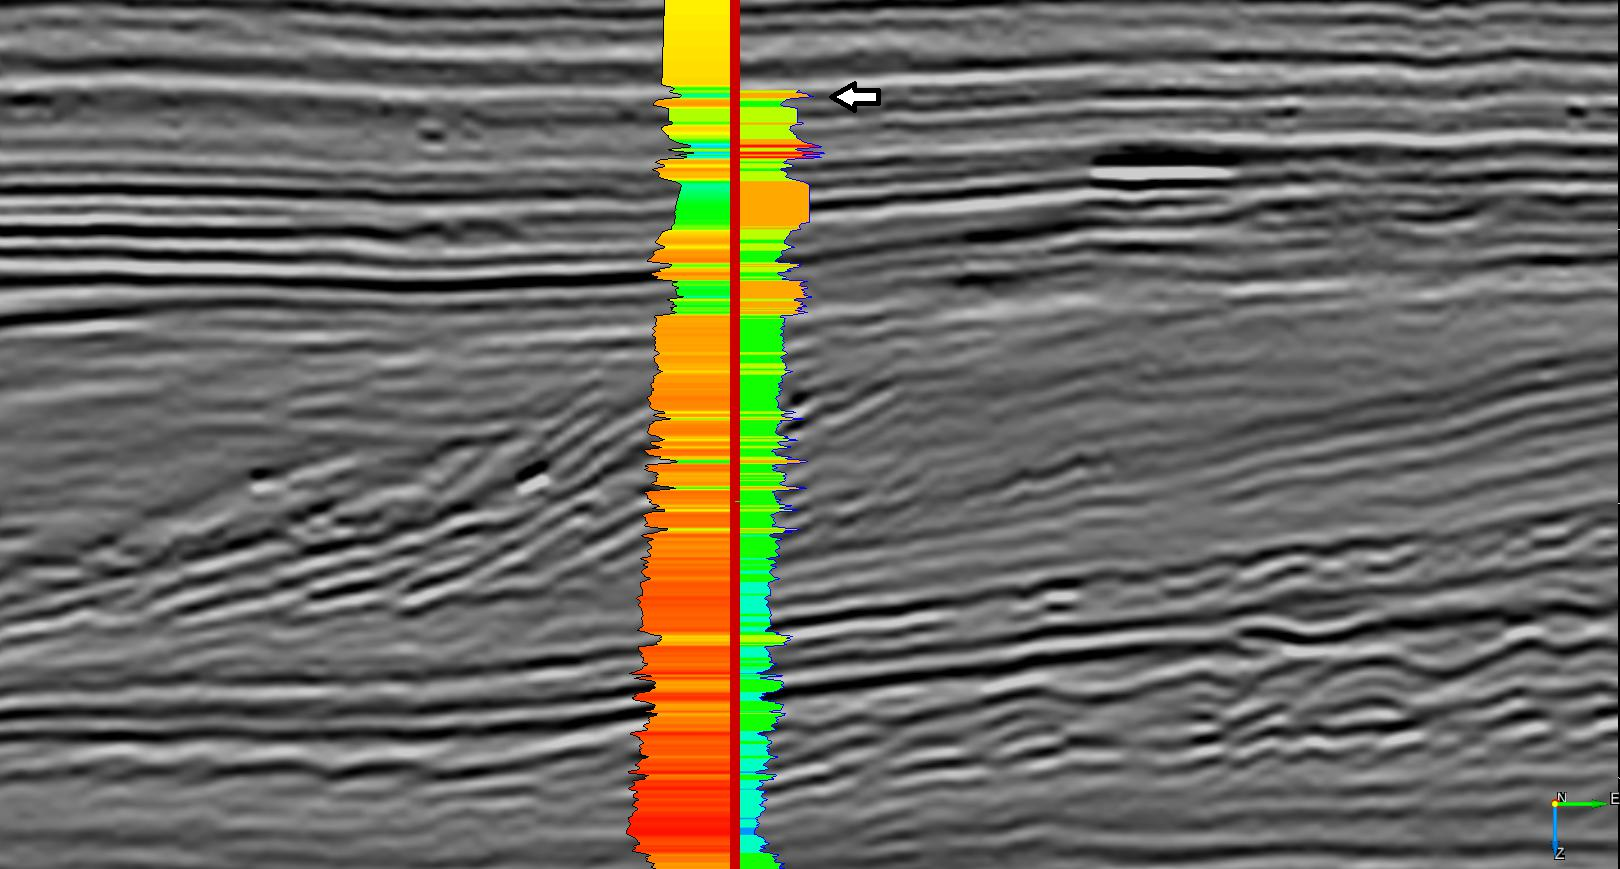

In [7]:
Image(filename='/content/drive/MyDrive/Colab Notebooks/Well_F03-4.png', width=500, height=600)

Intervalo de interés en profundidad

In [8]:
z = z[3298:12201]

In [9]:
tini = 0.5
sca_dt = 0.1524 * np.nan_to_num(dtco[3298:12201]) / 1e6
tacum = tini + 2 * np.cumsum(sca_dt)

In [10]:
print('Tiempo total = ', max(np.round(tacum,2)),'[s]')

Tiempo total =  1.81 [s]


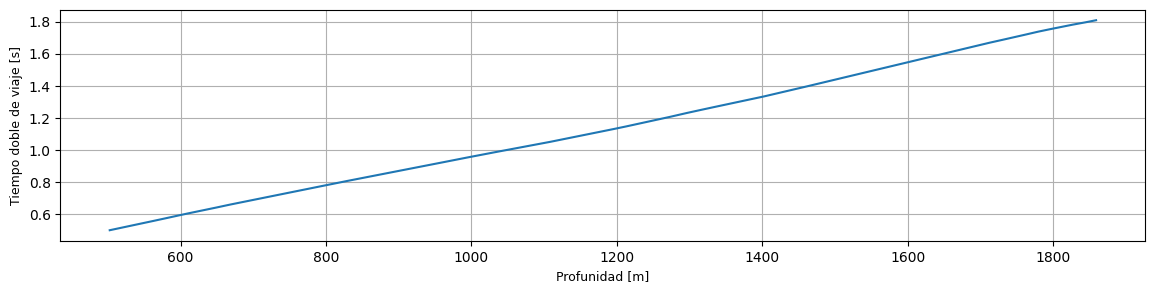

In [11]:
plt.figure(figsize=(14,3))

_ = plt.plot(z, tacum)
_ = plt.xlabel('Profunidad [m]', fontsize='9')
_ = plt.ylabel('Tiempo doble de viaje [s]', fontsize='9')
_ = plt.grid(True)

### Impedancia acústica en el dominio de la profundidad

In [12]:
imp = den[3298:12201]*1e6/dtco[3298:12201]

In [13]:
imp = imp.values

In [14]:
print('Tipo de dato de imp : ',type(imp))

Tipo de dato de imp :  <class 'numpy.ndarray'>


### Serie de coeficientes de reflectividad en el dominio de la profundidad

In [15]:
scr = (imp[1:] - imp[:-1]) / (imp[1:] + imp[:-1])

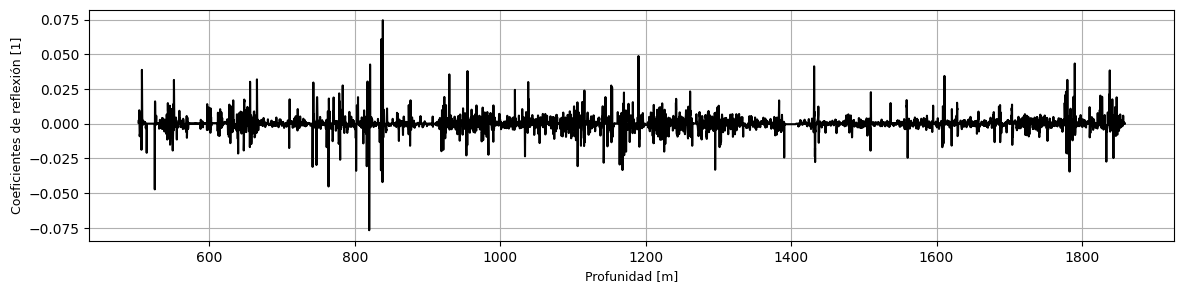

In [16]:
plt.figure(figsize=(14,3))

_ = plt.plot(z[:-1], scr, 'k')
_ = plt.xlabel('Profunidad [m]', fontsize='9')
_ = plt.ylabel('Coeficientes de reflexión [1]', fontsize='9')
_ = plt.grid(True)

### Conversión de la impendancia acústica al dominio del tiempo (impt) a través de una función de interpolación [np.interp](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.interp.html)

In [17]:
dt = 0.004 #Intervalo de muestreo
maxt = 1.81 # Tiempo total
t = np.arange(0.5, maxt, dt)

In [18]:
impt = np.interp(x = t, xp = tacum, fp = imp)

### Serie de coeficientes de reflexión en el dominio del tiempo (scrt)

In [19]:
scrt = (impt[1:] - impt[:-1]) / (impt[1:] + impt[:-1])

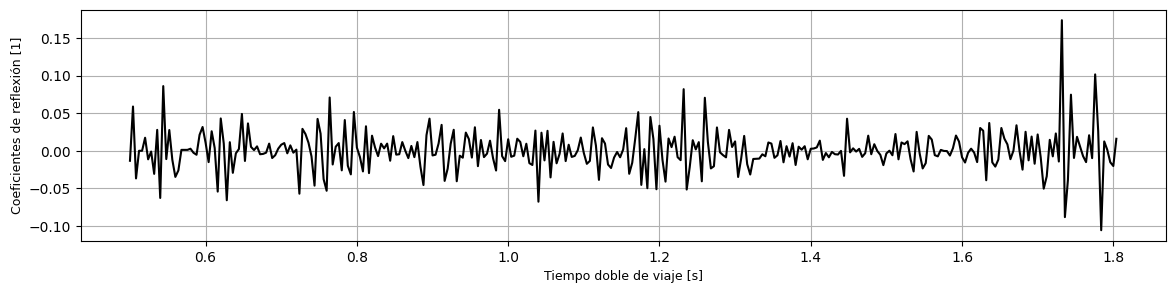

In [20]:
plt.figure(figsize=(14,3))

_ = plt.plot(t[:-1], scrt, 'k')
_ = plt.xlabel('Tiempo doble de viaje [s]', fontsize='9')
_ = plt.ylabel('Coeficientes de reflexión [1]', fontsize='9')
_ = plt.grid(True)

### Lentitud de onda P en el dominio del tiempo (dtcot)

In [21]:
dtcot = np.interp(x = t, xp = tacum, fp = dtco[3298:12201])

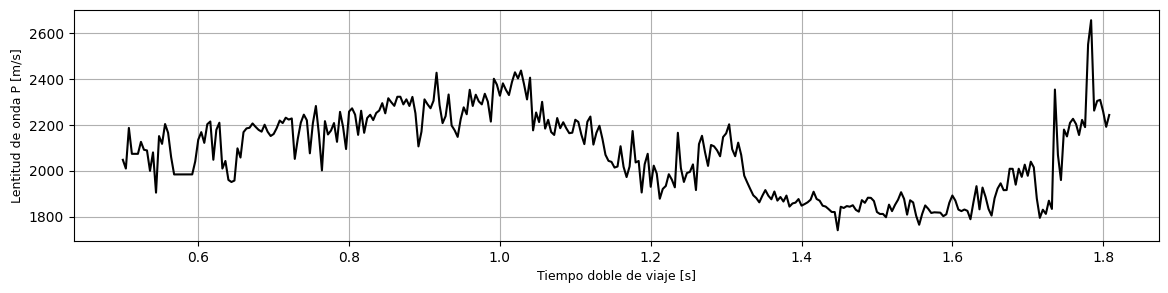

In [22]:
plt.figure(figsize=(14,3))

_ = plt.plot(t, 1e6/dtcot, 'k')
_ = plt.xlabel('Tiempo doble de viaje [s]', fontsize='9')
_ = plt.ylabel('Lentitud de onda P [m/s]', fontsize='9')
_ = plt.grid(True)

### Ondícula de Ricker

In [23]:
def ricker(frec, lon, dt):
    t = np.arange(-lon / 2, (lon-dt) / 2, dt)
    y = (1.0 - 2.0*(np.pi**2)*(frec**2)*(t**2))*np.exp(-(np.pi**2)*(frec**2)*(t**2))
    return t, y

In [24]:
tw, wt = ricker(frec=25, lon = 248e-3, dt = 4e-3) # tw:tiempo ondícula, wt:ondícula

In [25]:
tss = np.convolve(wt, scrt, mode='same') # tss:traza sísmica sintética

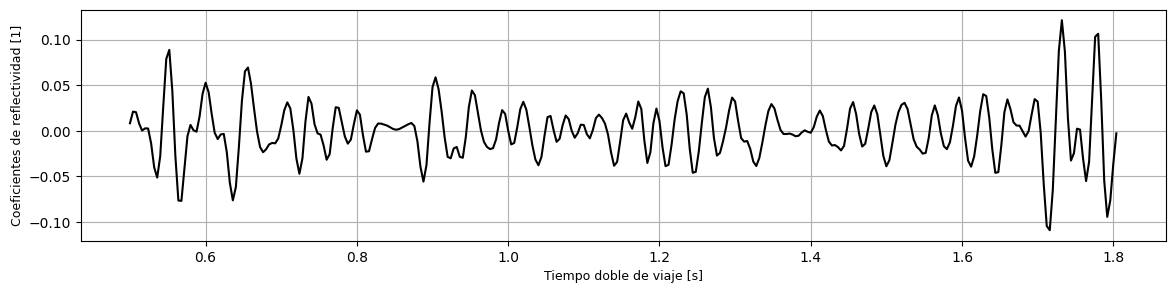

In [26]:
plt.figure(figsize=(14,3))

_ = plt.plot(t[:-1], tss, 'k')
_ = plt.xlabel('Tiempo doble de viaje [s]', fontsize='9')
_ = plt.ylabel('Coeficientes de reflectividad [1]', fontsize='9')
_ = plt.grid(True)

### Integración de resultados

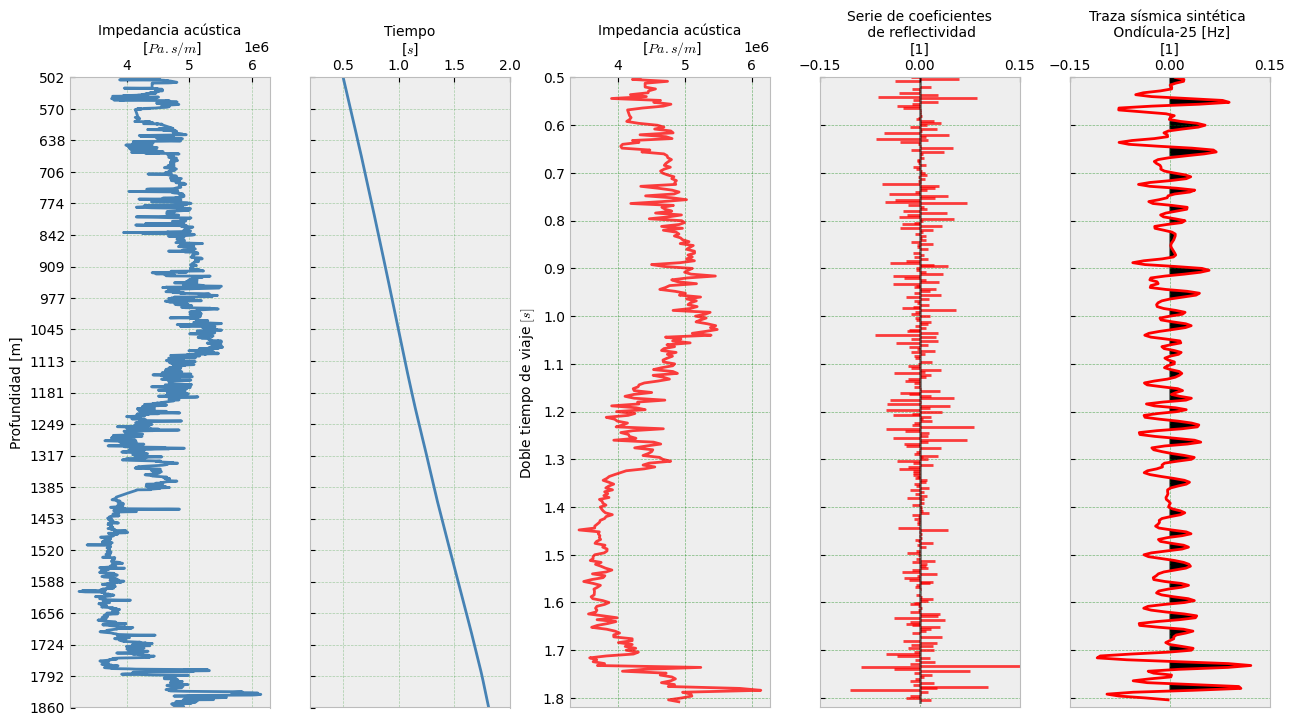

In [27]:
################################
f1 = plt.figure(figsize = [10,9])
plt.style.use('bmh')

################################
################################

# Impedancia acústica en el dominio de la profundidad
curv1 = f1.add_axes([0, 0, 0.2,0.7]) #Define la posición del carril [abscisa al origen, ordenada al origen, ancho, alto]
curv1.plot(den[3298:12201]*1e6/dtco[3298:12201], z,'steelblue', alpha=1, lw=2)
curv1.set_xlabel('Impedancia acústica\n '+ '[$Pa.s/m$]', fontsize = '10' )
curv1.set_ylabel('Profundidad ' + '[m]', fontsize = '10' )
curv1.set_ylim(502.6152, 1859.4324)
#curv1.set_xlim(1600, 2600)
curv1.set_yticks(np.linspace (502,1860,21) )
curv1.xaxis.tick_top()
curv1.xaxis.set_label_position('top')
curv1.invert_yaxis()
curv1.grid(True, c="g", alpha=0.3)

# Curva tiempo a profundidad
curv2 = f1.add_axes([0.24, 0, 0.2,0.7])
curv2.plot(tacum, z,'steelblue', alpha=1, lw=2)
curv2.set_xlabel('Tiempo\n'+ '[$s$]', fontsize = '10' )
curv2.set_ylim(502.6152, 1859.4324)
curv2.set_xlim(0.2, 2.0)
curv2.set_yticks(np.linspace (502,1860,21))
curv2.set_yticklabels('')
curv2.xaxis.tick_top()
curv2.xaxis.set_label_position('top')
curv2.invert_yaxis()
curv2.grid(True, c="g", alpha=0.3)

# Impedancia acústica en el dominio del tiempo
curv3 = f1.add_axes([0.50, 0.0, 0.2, 0.7])
curv3.plot(impt, t,'r', alpha=0.75, lw=2)
curv3.set_xlabel('Impedancia acústica\n ' + '[$Pa.s/m$]' , fontsize ='10' )
curv3.set_ylabel('Doble tiempo de viaje ' + '$[s]$', fontsize = '10' )
curv3.set_ylim(0.500, 1.82)
#curv3.set_xlim(1600, 2600)
#curv5.set_xticks(np.linspace(0, 2*1e4, 5))
curv3.set_yticks(np.linspace(0.5 , 1.8, 14))
curv3.xaxis.tick_top()
curv3.xaxis.set_label_position('top')
curv3.invert_yaxis()
curv3.grid(True, c="g", alpha=0.5)

# Serie de coeficientes de reflectividad en el dominio del tiempo
curv4 = f1.add_axes([0.75, 0.0, 0.2, 0.7])
curv4.hlines(t[:-1], 0, scrt, color='r', alpha= 0.75, lw = 2 )
curv4.plot([0, 0], [t.min(), t.max()], '-', c='k', alpha = 0.5)
curv4.set_xlabel('Serie\n de\n reflectividad\n' + '[1]', fontsize ='10' )
curv4.set_xlabel('Serie de coeficientes\n de reflectividad\n' + '[1]', fontsize ='10' )
curv4.set_ylim(0.500, 1.82)
curv4.set_xlim(-0.15, 0.15)
curv4.set_yticklabels('')
curv4.xaxis.tick_top()
curv4.set_yticks(np.linspace(0.5 , 1.8, 14))
curv4.set_xticks([-0.15, 0, 0.15] )
curv4.xaxis.set_label_position('top')
curv4.invert_yaxis()
curv4.grid(True, c="g", alpha=0.5)

#Traza sísmica sintética sintética en el dominio del tiempo
tamp = t[:-1]
curv5 = f1.add_axes([1.0, 0.0, 0.2, 0.7])
curv5.plot(tss, tamp,'r')
curv5.fill_betweenx(t[:-1], tss,  0,  tss > 0.0,  color='k', alpha = 1.0)
curv5.set_xlabel('Traza sísmica sintética \n Ondícula-25 [Hz]\n' + '[1]', fontsize ='10' )
curv5.set_ylim(0.500, 1.82)
curv5.set_xlim(-0.15, 0.15)
curv5.set_yticklabels('')
curv5.xaxis.tick_top()
curv5.set_yticks(np.linspace(0.5 , 1.8, 14))
curv5.set_xticks([-0.15, 0, 0.15] )
curv5.xaxis.set_label_position('top')
curv5.invert_yaxis()
curv5.grid(True, c="g", alpha=0.5)

plt.show()


**Utilizando ChatGPT-4, se calculó el sismograma sintético a través de la siguientes instrucciones:**


1. Read the file in CSV format. Values of -9999 indicate "Not a Number." The units are microsecond per meter (us/m), kilogram per cubic meter (kg/m³), and meters (m) for P_Slowness, Density, and Depth. Convert P_Slowness to P-wave velocity in m/s.
2. Create a plot for the "Two-way-time" of  "P-wave velocity." Use a depth interval of 0.1524 m and an initial time of 0.5 s.
3. Using the "Two-way-time” curve, convert P-wave velocity and Density curves for depths ranging from 502 to 1860 m in time domain, and calculate the "Acoustic impedance". Interpolate the data using a vector "t" where t _start is equal to 0.5 s, t_end is equal to 1.81 s, and the sampling interval is equal to 0.004 s.
4. Based on the "Acoustic Impedance" curve in time domain, compute a synthetic seismogram using a 25 Hz Ricker wavelet. Assume the wavelet length is equal to 0.248 s.
5. Export result in csv format.

Se importa el resultado, se grafica y compara.

In [34]:
traza_chatgpt4='/content/drive/MyDrive/Colab Notebooks/synthetic_seismogram.csv'

In [29]:
traza_chatgpt4=pd.read_csv(traza_chatgpt4)

In [30]:
traza_chatgpt4.columns

Index(['Two-way-time', 'Amplitude'], dtype='object')

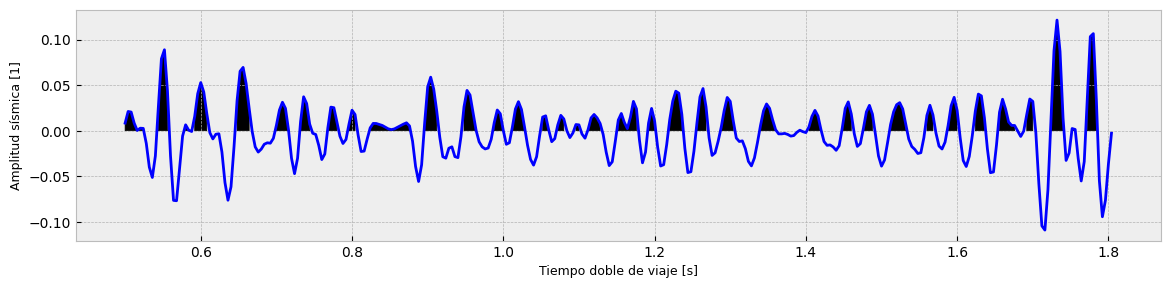

In [31]:
plt.figure(figsize=(14,3))

_ = plt.plot(traza_chatgpt4['Two-way-time'], traza_chatgpt4["Amplitude"], 'blue')
_ = plt.xlabel('Tiempo doble de viaje [s]', fontsize ='9')
_ = plt.ylabel('Amplitud sísmica [1]', fontsize ='9')
_ = plt.fill_between(traza_chatgpt4['Two-way-time'], traza_chatgpt4["Amplitude"],  0,  tss > 0.0,  color='k', alpha = 1.0)
_ = plt.grid(True)

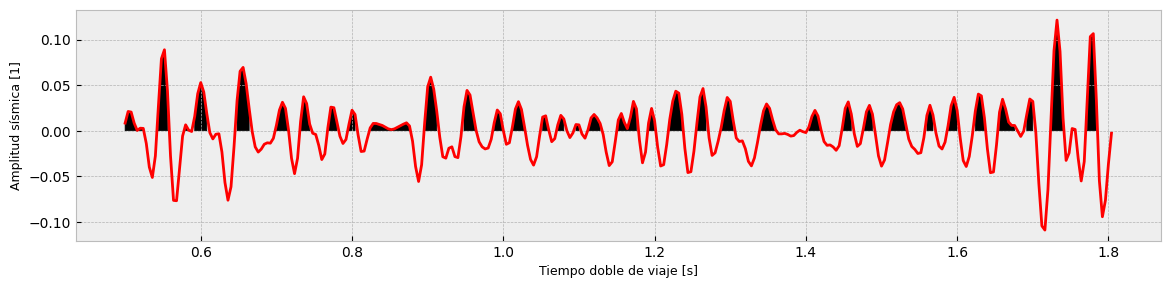

In [32]:
plt.figure(figsize=(14,3))

_ = plt.plot(tamp, tss, 'r')
_ = plt.xlabel('Tiempo doble de viaje [s]', fontsize ='9')
_ = plt.ylabel('Amplitud sísmica [1]', fontsize ='9')
_ = plt.fill_between(tamp, tss,  0,  tss > 0.0,  color='k', alpha = 1.0)
_ = plt.grid(True)

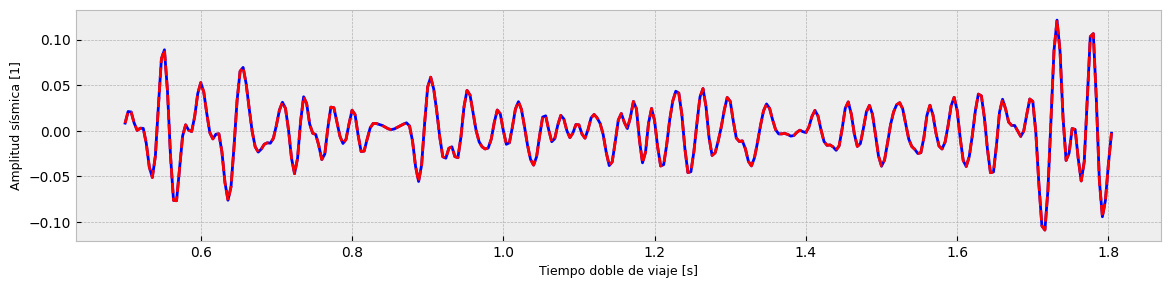

In [33]:
plt.figure(figsize=(14,3))

_ = plt.plot(tamp, tss, 'blue')
_ = plt.plot(traza_chatgpt4['Two-way-time'], traza_chatgpt4["Amplitude"], '--r')
_ = plt.xlabel('Tiempo doble de viaje [s]', fontsize ='9')
_ = plt.ylabel('Amplitud sísmica [1]', fontsize ='9')